## Import 3rd party dependencies

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn import svm

## Load training data

In [48]:
data = pd.read_csv("archive/train.csv")
print(data)

      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0               842     0          2.2         0   1       0           7   
1              1021     1          0.5         1   0       1          53   
2               563     1          0.5         1   2       1          41   
3               615     1          2.5         0   0       0          10   
4              1821     1          1.2         0  13       1          44   
...             ...   ...          ...       ...  ..     ...         ...   
1995            794     1          0.5         1   0       1           2   
1996           1965     1          2.6         1   0       0          39   
1997           1911     0          0.9         1   1       1          36   
1998           1512     0          0.9         0   4       1          46   
1999            510     1          2.0         1   5       1          45   

      m_dep  mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  \
0       

## Data Preprocessing

#### Convert labels into to two classes: low (0, 1) and high (2, 3)

In [49]:
data["price_classification"] = np.where(data["price_range"] <= 1, 0, 1)
print(data.head())

   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_width   ram  sc_h  sc_w  talk_time  three_g  \
0        188        2  ...       756  2549     9     7         19        0   
1        136        3  ...      1988  2631    17     3          7        1   
2        145        5  ...      1716  2603    11     2          9        1   
3        131        6  ...      1786  2769    16     8         11        1   
4        141        2  ...      1212  1411     8     2         15        1   

   touch_screen  wifi  price_range  price_classifi

#### Split the original ‘train.csv’ into ‘train.csv’, ‘valid.csv’ and ‘test.csv’ with the ratio of 0.8 : 0.1 : 0.1

In [50]:
x = data
y = data["price_range"]
train_data, tmp_x, train_y, tmp_y = train_test_split(x, y, test_size = 0.2, random_state = 101, stratify = y)
test_data, valid_data, test_y, valid_y = train_test_split(tmp_x, tmp_y, test_size = 0.5, random_state = 101, stratify = tmp_y)

#### Test whether the split works correctly

In [51]:
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)
print(train_data.head())

(1600, 22)
(200, 22)
(200, 22)
      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
1569           1494     0          2.4         0   6       1           3   
1668            962     0          1.0         1  14       0           2   
1989            586     0          2.8         0   2       0          15   
1609           1148     0          2.3         1   0       1          58   
1424           1352     0          2.4         0   5       1           6   

      m_dep  mobile_wt  n_cores  ...  px_width   ram  sc_h  sc_w  talk_time  \
1569    0.9         93        7  ...      1003  1208    14    13         17   
1668    0.9        125        1  ...      1916  1491    16     2         14   
1989    0.2         83        3  ...       854  2592    12     8          3   
1609    0.3        170        5  ...       688  3127    10     7         11   
1424    0.9         92        6  ...      1299  1309    12     1         14   

      three_g  touch_screen  wifi  pr

#### Write the data back to the csv file

In [52]:
train_data.to_csv("train.csv")
test_data.to_csv("test.csv")
valid_data.to_csv("valid.csv")

## Model Implementation

### The Sigmoid function

In [53]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Logistic Regression

In [54]:
class LogisticRegression():
    def __init__(self, learning_rate=.1, n_iterations=8000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def initialize_weights(self, n_features):
        limit = np.sqrt(1 / n_features)
        w = np.random.uniform(-limit, limit, (n_features, 1))
        b = 0
        # Insert 0 as w_0
        self.w = np.insert(w, 0, b, axis=0)

    def fit(self, X, y):
        normal_X = normalize(X, norm = 'max')
        m_samples, n_features = normal_X.shape
        self.initialize_weights(n_features)
        # Insert a column of 1 as x_0
        normal_X = np.insert(normal_X, 0, 1, axis=1)
        y = np.reshape(y, (m_samples, 1))
        for i in range(self.n_iterations):
            h_x = normal_X.dot(self.w)
            y_pred = sigmoid(h_x)
            w_grad = normal_X.T.dot(y_pred - y)
            self.w = self.w - self.learning_rate * w_grad
        return self.w

    def predict(self, X):
        normal_X = normalize(X, norm = 'max')
        normal_X = np.insert(normal_X, 0, 1, axis=1)
        h_x = normal_X.dot(self.w)
        y_pred = np.round(sigmoid(h_x))
        return y_pred.astype(int)

    def test(self, X, y):
        y_pred = self.predict(X)
        right_count = 0
        m_samples = X.shape[0]
        for i in range(m_samples):
            if y_pred[i] == y[i]:
                right_count += 1
        return right_count / m_samples 

### Naive Bayes

In [55]:
class NaiveBayes():
    def __init__(self, continuous, uncontinuous):
        self.continuous = continuous
        self.uncontinuous = uncontinuous

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        self.parameters = {}
        for i, c in enumerate(self.classes):
            # Calculate prior probability of every class
            prior = y.values[np.where(self.y == c)].shape[0] / self.y.shape[0]
            # Calculate likelihood of every continuous attribute
            likelihood_con = {}
            for item in self.continuous:
                X_index_c_con = self.X[item].values[np.where(self.y == c)]
                X_index_c_con_mean = np.mean(X_index_c_con)
                X_index_c_con_var = np.var(X_index_c_con)
                likelihood_con[item] = {"mean": X_index_c_con_mean, "var": X_index_c_con_var}
            # Calculate likelihood of every uncontinuous attribute
            likelihood_uncon = {}
            for item in self.uncontinuous:
                X_index_c_uncon = self.X[item].values[np.where(self.y == c)]
                classes = np.unique(X_index_c_uncon)
                likelihood = {}
                for class_item in classes:
                    likelihood[class_item] = X_index_c_uncon[np.where(X_index_c_uncon == class_item)].shape[0] / X_index_c_uncon.shape[0]
                likelihood_uncon[item] = {"likelihoods": likelihood}
                    # print(X_index_c_uncon[np.where(X_index_c_uncon == class_item)].shape[0])
            self.parameters[c] = {"prior": prior, "likelihood_con": likelihood_con, "likelihood_uncon": likelihood_uncon}    
        return self.parameters

    def predict(self, X):
        # Calculate post probability of every class : P(C_i | x_1 x_2 ... x_n) = P(C_i)P(x_1 | C_i)P(x_2 | C_i)...P(x_n | C_i)
        output = []
        m_samples = X.shape[0]
        # For every sample
        for i in range(m_samples):
            max = float('-inf')
            chosen = 0
            for c in self.classes:
                prior = self.parameters[c]["prior"]
                likelihood_log = 0
                # For every uncontinuous attribute
                for a in self.uncontinuous:
                    x = X[a][i : i + 1].values
                    probability = self.parameters[c]["likelihood_uncon"][a]["likelihoods"][x[0]]
                    likelihood_log += np.log(probability)
                # For every continuous attribute
                for a in self.continuous:
                    mean = self.parameters[c]["likelihood_con"][a]["mean"]
                    var = self.parameters[c]["likelihood_con"][a]["var"]
                    x = X[a][i : i + 1].values
                    probability = self.gaussian_probability(mean, var, x[0])
                    likelihood_log += np.log(probability)
                post_log = np.log(prior) + likelihood_log
                if post_log > max:
                    max = post_log
                    chosen = c
            output.append(chosen)
        return output

    def gaussian_probability(self, mean, var, x):
        eps = 1e-4
        numerator = np.exp(-(x - mean) ** 2 / (2 * var + eps))
        denominator = np.sqrt(2 * np.pi * var + eps)
        result = numerator / denominator
        return result

    def test(self, X, y):
        output = self.predict(X)
        right_count = 0
        m_samples = X.shape[0]
        for i in range(m_samples):
            if output[i] == y.values[i]:
                right_count += 1
        return right_count / m_samples 


## Train models

### Decide what fields we want to process

In [56]:
output_param_name = 'price_classification'
price_range = 'price_range'

### Split training set and test set into input and output

In [57]:
x_train = train_data.drop(output_param_name,axis=1,inplace=False).drop(price_range,axis=1,inplace=False)
y_train = train_data[output_param_name]
x_test = test_data.drop(output_param_name,axis=1,inplace=False).drop(price_range,axis=1,inplace=False)
y_test = test_data[output_param_name]

#### Check whether the split works correctly

In [58]:
print(x_train[0 : 1])
# print(y_train)
# print(x_test)
# print(y_test)

      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
1569           1494     0          2.4         0   6       1           3   

      m_dep  mobile_wt  n_cores  pc  px_height  px_width   ram  sc_h  sc_w  \
1569    0.9         93        7  17        944      1003  1208    14    13   

      talk_time  three_g  touch_screen  wifi  
1569         17        1             1     0  


### Train Logistic Regression Model

In [59]:
logistic_regression = LogisticRegression()
theta = logistic_regression.fit(x_train.values, y_train.values)

#### Print model parameters

In [60]:
theta_table = pd.DataFrame({'Model Parameters': theta.flatten()})
print(theta_table)

    Model Parameters
0        -163.206506
1          10.286324
2         -10.984862
3         -30.539150
4         -12.750083
5         -66.740531
6         -11.714454
7        -524.237348
8         -12.645808
9       -1291.420796
10        -86.415434
11       -192.632028
12         40.026309
13        -36.290573
14        241.140530
15       -286.105300
16       -113.111160
17       -266.079968
18        -15.220621
19        -13.593533
20        -10.825531


### Train Naive Bayes Model

#### Continuous attributes

In [61]:
continuous = [
    'battery_power',
    'clock_speed',
    'fc',
    'int_memory',
    'm_dep',
    'mobile_wt',
    'pc',
    'px_height',
    'px_width',
    'ram',
    'sc_h',
    'sc_w',
    'talk_time'
]
uncontinuous = [
    'blue',
    'dual_sim',
    'four_g',
    'n_cores',
    'three_g',
    'touch_screen',
    'wifi'
]

In [62]:
naive_bayes = NaiveBayes(continuous, uncontinuous)
params = naive_bayes.fit(x_train, y_train)

#### Print parameters

In [63]:
print("Parameters of Naive Bayes Model: ", params)

Parameters of Naive Bayes Model:  {0: {'prior': 0.5, 'likelihood_con': {'battery_power': {'mean': 1169.195, 'var': 183449.47697499997}, 'clock_speed': {'mean': 1.48875, 'var': 0.6891484374999999}, 'fc': {'mean': 4.1675, 'var': 18.80194375}, 'int_memory': {'mean': 31.64625, 'var': 331.7836109375}, 'm_dep': {'mean': 0.51625, 'var': 0.08251093749999999}, 'mobile_wt': {'mean': 140.03625, 'var': 1283.7199359375}, 'pc': {'mean': 9.6225, 'var': 37.002493750000006}, 'px_height': {'mean': 593.73625, 'var': 171561.27418593748}, 'px_width': {'mean': 1200.53, 'var': 182335.3341}, 'ram': {'mean': 1233.5, 'var': 371179.87}, 'sc_h': {'mean': 12.345, 'var': 17.748475}, 'sc_w': {'mean': 5.59125, 'var': 17.5666734375}, 'talk_time': {'mean': 10.98, 'var': 29.9696}}, 'likelihood_uncon': {'blue': {'likelihoods': {0: 0.52125, 1: 0.47875}}, 'dual_sim': {'likelihoods': {0: 0.49625, 1: 0.50375}}, 'four_g': {'likelihoods': {0: 0.48875, 1: 0.51125}}, 'n_cores': {'likelihoods': {1: 0.1325, 2: 0.13375, 3: 0.12875,

### Train SVM Model

In [64]:
clf = svm.SVC()
clf.fit(x_train.values, y_train.values)

SVC()

## Test models

### Test Logistic Regression Model

In [65]:
accuracy_result_1 = logistic_regression.test(x_test.values, y_test.values)
print('Accuracy of Logistic Regression Model: {:.2f}' .format(accuracy_result_1))

Accuracy of Logistic Regression Model: 0.84


### Test Naive Bayes Model

In [66]:
accuracy_result_2 = naive_bayes.test(x_test, y_test)
print('Accuracy of Naive Bayes Model: {:.2f}' .format(accuracy_result_2))

Accuracy of Naive Bayes Model: 0.94


### Test SVM Model

In [67]:
accuracy_result_3 = clf.score(x_test.values, y_test.values)
print('Accuracy of SVM Model: {:.2f}' .format(accuracy_result_3))

Accuracy of SVM Model: 0.98


## Empirical Study

### Compare the three methods with respect to the classification accuracy on the test set

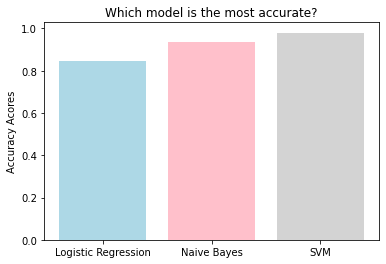

In [68]:
models = ['Logistic Regression', 'Naive Bayes', 'SVM']
acc_scores = [accuracy_result_1, accuracy_result_2, accuracy_result_3]

plt.bar(models, acc_scores, color=['lightblue', 'pink', 'lightgrey', 'cyan'])
plt.ylabel("Accuracy Acores")
plt.title("Which model is the most accurate?")
plt.show()